In [ ]:
# ..... Seurat integration by stage - 8 samples, SCTransform + CCA ..... #
# _data files have filtered out doublets, cells with <200 genes expressed,
# cells with >200 but <12,000 UMI, and MT ratio >0.4

In [2]:
library(Seurat)
library(SeuratDisk)

In [3]:
# list of stages and samples
stages = rep(c('stage14', 'stage17', 'stage21'), each = 3)
samples = paste0('sample', c('4', '7', '8A', '3_Triangle', '5B', '5Y', '1A', '1B', '2'))

In [16]:
id1 = 7
id2 = 8
id3 = 9

# load data
sc1 = readRDS(paste0(stages[id1], '_', samples[id1], '_data.rds'))
sc1$dataset = paste0('s', sub('\\.*sample', '', samples[id1]))

sc2 = readRDS(paste0(stages[id2], '_', samples[id2], '_data.rds'))
sc2$dataset = paste0('s', sub('\\.*sample', '', samples[id2]))

sc3 = readRDS(paste0(stages[id3], '_', samples[id3], '_data.rds'))
sc3$dataset = paste0('s', sub('\\.*sample', '', samples[id3]))

ifnb.list = list(sc1, sc2, sc3)

In [17]:
# normalize and identify variable features for each dataset independently
# SCTransform normalization
ifnb.list <- lapply(X = ifnb.list, FUN = SCTransform, method = "glmGamPoi") # faster
features <- SelectIntegrationFeatures(object.list = ifnb.list, nfeatures = 3000)
ifnb.list <- PrepSCTIntegration(object.list = ifnb.list, anchor.features = features)
ifnb.list <- lapply(X = ifnb.list, FUN = RunPCA, features = features)

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 17719 by 7968

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 5000 cells

Found 139 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 17719 genes

Computing corrected count matrix for 17719 genes

Calculating gene attributes

Wall clock passed: Time difference of 26.51288 secs

Determine variable features

Centering data matrix

Place corrected count matrix in counts slot

Set default assay to SCT

Running SCTransform on assay: RNA

vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

Calculating cell attributes from input UMI matrix: log_umi

Variance stabilizing transformation of count matrix of size 18

In [18]:
# identify anchors and integrate data
immune.anchors <- FindIntegrationAnchors(object.list = ifnb.list, normalization.method = "SCT",
    anchor.features = features, dims = 1:30, reduction = "rpca", k.anchor = 20)
immune.combined.sct <- IntegrateData(anchorset = immune.anchors, normalization.method = "SCT", dims = 1:30)

Computing within dataset neighborhoods

Finding all pairwise anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 37905 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 47995 anchors

Projecting new data onto SVD

Projecting new data onto SVD

Finding neighborhoods

Finding anchors

	Found 31398 anchors



[1] 1


Warning message:
“Different cells and/or features from existing assay SCT”


[1] 2


Warning message:
“Different cells and/or features from existing assay SCT”


[1] 3


Warning message:
“Different cells and/or features from existing assay SCT”
Merging dataset 1 into 3

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Merging dataset 2 into 3 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Warning message:
“Assay integrated changing from Assay to SCTAssay”
Warning message:
“Different cells and/or features from existing assay SCT”


In [19]:
# run pca, umap
immune.combined.sct <- RunPCA(immune.combined.sct, verbose = FALSE)
immune.combined.sct <- RunUMAP(immune.combined.sct, reduction = "pca", dims = 1:30)

# cluster integrated data
immune.combined.sct <- FindNeighbors(immune.combined.sct, reduction = "pca", dims = 1:30)
immune.combined.sct <- FindClusters(immune.combined.sct, resolution = 0.5)

13:31:11 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:31:11 Read 25515 rows and found 30 numeric columns

13:31:11 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

13:31:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:31:14 Writing NN index file to temp file /tmp/RtmpsQ7t4P/fileb769cbd97b9b

13:31:14 Searching Annoy index using 1 thread, search_k = 3000

13:31:21 Annoy recall = 100%

13:31:22 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

13:31:23 Initializing from normalized Laplacian + 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 25515
Number of edges: 970506

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9285
Number of communities: 21
Elapsed time: 4 seconds


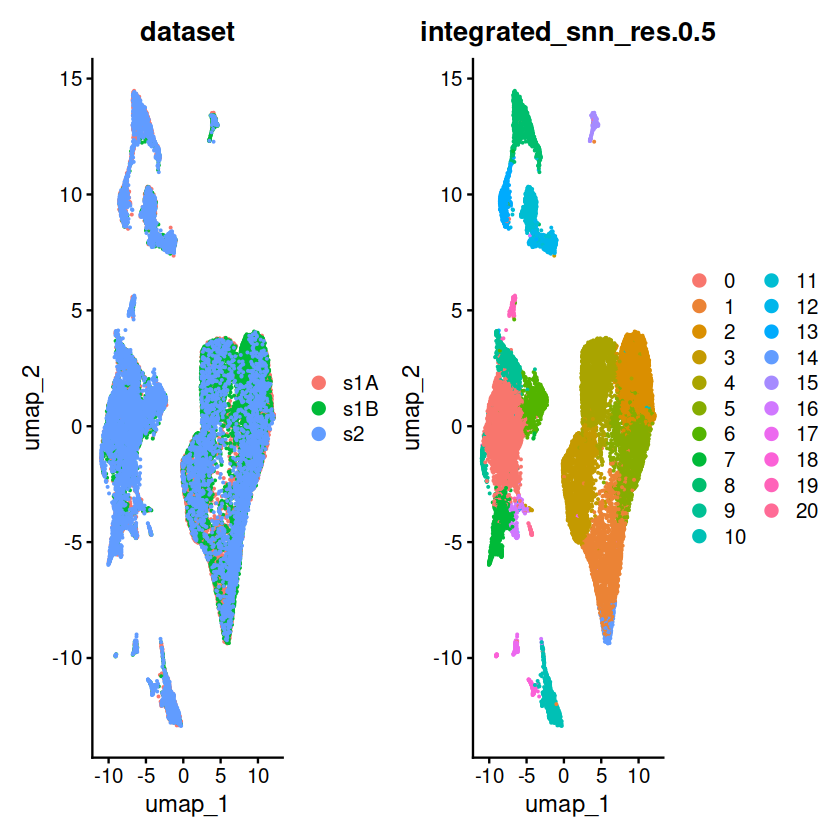

In [20]:
# plot integrated umap
DimPlot(immune.combined.sct, reduction = "umap", group.by = c("dataset","integrated_snn_res.0.5"))

In [21]:
# save
saveRDS(immune.combined.sct, file = 'stage21_integrated_rpca.rds')

In [ ]:
# ............................................................................. #

In [13]:
# For performing differential expression after integration, we switch back to the original data
DefaultAssay(immune.combined.sct) <- "RNA"
nk.markers <- FindConservedMarkers(immune.combined.sct, ident.1 = 6, 
                                   grouping.var = "dataset", verbose = FALSE)
head(nk.markers)

s3_p_val      s3_avg_log2FC s3_pct.1 s3_pct.2 s3_p_val_adj 
ENSGALG00010005008  2.627029e-83 0.3364214     0.164    0.020     4.467789e-79
ENSGALG00010021609 5.924945e-155 0.8814869     0.832    0.303    1.007655e-150
PEX5L              2.153936e-124 0.7721261     0.642    0.210    3.663198e-120
HHLA2              6.952055e-181 1.1272285     0.961    0.376    1.182336e-176
LRRTM3             7.128040e-159 1.0512835     0.912    0.393    1.212266e-154
KIF26B             1.530353e-168 0.9370231     0.875    0.377    2.602672e-164
                   s10_p_val     s10_avg_log2FC s10_pct.1 s10_pct.2
ENSGALG00010005008  0.000000e+00 0.6020463      0.291     0.020    
ENSGALG00010021609 7.019583e-270 0.9179653      0.852     0.272    
PEX5L              6.662077e-238 0.8949365      0.822     0.269    
HHLA2              2.920157e-236 1.0147847      0.966     0.447    
LRRTM3             4.425231e-215 0.9966317      0.938     0.427    
KIF26B             2.529425e-208 0.8446940      0.916     0.434    
                   s10_p_val_adj max_pval      minimump_p_val
ENSGALG00010005008  0.000000e+00  2.627029e-83  0.000000e+00 
ENSGALG00010021609 1.193820e-265 5.924945e-155 1.403917e-269 
PEX5L              1.133019e-233 2.153936e-124 1.332415e-237 
HHLA2              4.966311e-232 6.952055e-181 5.840314e-236 
LRRTM3             7.525990e-211 7.128040e-159 8.850462e-215 
KIF26B             4.301793e-204 1.530353e-168 5.058849e-208

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”


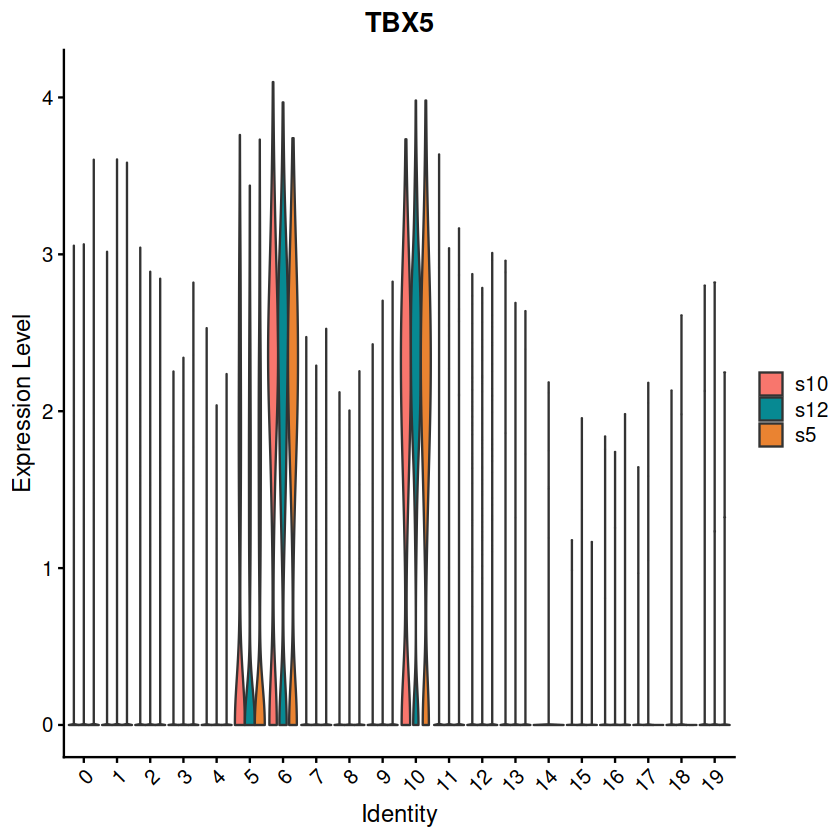

Warning message:
“Groups with fewer than two data points have been dropped.”


[[1]]

[[2]]

[[3]]


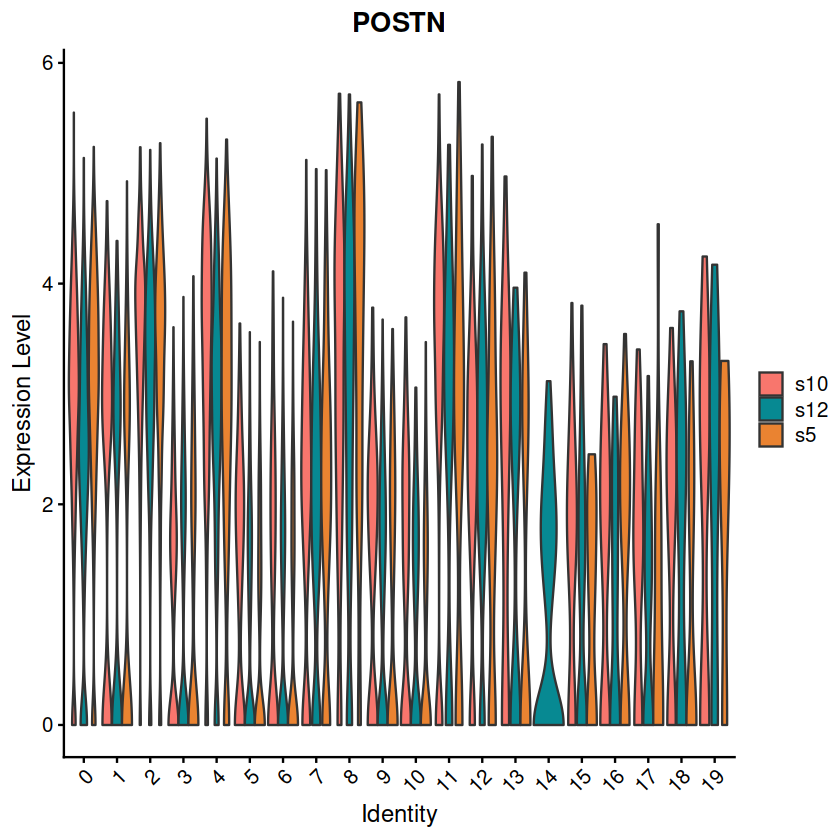

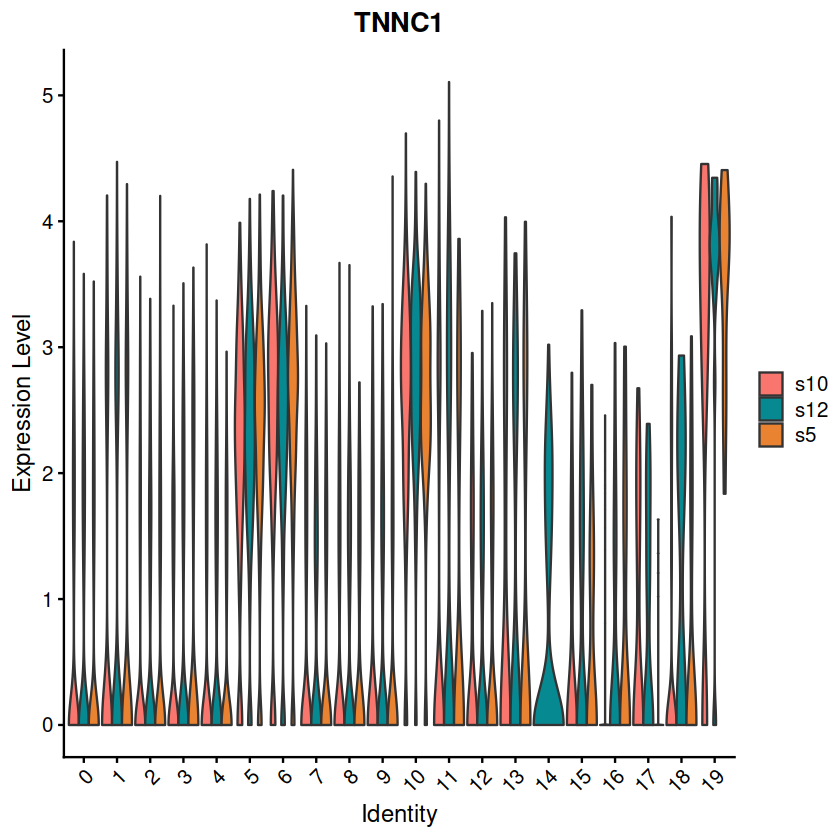

In [47]:
DefaultAssay(immune.combined.sct) <- "RNA"
VlnPlot(immune.combined.sct, features = c("TBX5", "POSTN", "TNNC1"), split.by = "dataset",
        group.by = "integrated_snn_res.0.5", pt.size = 0, combine = FALSE)